In [140]:
# !pip install xgboost 
# !pip install missingno
# !pip install yellowbrick
try :
    import joblib 
except: pass 
from copy import deepcopy
import pickle 
import numpy as np 
import pandas as pd 
import missingno as msno
import matplotlib.pyplot as plt 
#from yellowbrick.classifer import ConfusionMatrix 
import seaborn as sns 
sns.set()
import warnings 
warnings.filterwarnings('ignore') 

from seaborn import boxplot 

import scikitplot 
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import load_digits
from sklearn.impute import SimpleImputer 
from sklearn.compose import ColumnTransformer 
from sklearn.dummy import DummyClassifier 
from sklearn.preprocessing import StandardScaler , OneHotEncoder
from sklearn.metrics import (confusion_matrix,
                            accuracy_score,
                            f1_score,
                            average_precision_score, 
                            roc_auc_score,
                            precision_score, 
                            recall_score, plot_roc_curve
    ) 
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC 
from sklearn.model_selection import (validation_curve,
                                    RandomizedSearchCV, 
                                    learning_curve,
                                    GridSearchCV ,
                                    cross_val_score, 
                                    train_test_split ,
                                    learning_curve,
                                    ShuffleSplit
   )
from sklearn.model_selection import ( KFold, 
                                    StratifiedKFold ,
                                    RepeatedStratifiedKFold
 )
from sklearn.ensemble import (
                           RandomForestClassifier ,
                           VotingClassifier, 
                           BaggingClassifier,
                           StackingClassifier,
                           AdaBoostClassifier, 
                           ExtraTreesClassifier, 
) 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier 

from xgboost import XGBClassifier 

from yellowbrick.classifier import ConfusionMatrix, ClassBalance 
from yellowbrick.classifier import (ROCAUC, 
                                    PrecisionRecallCurve , 
                                    ClassPredictionError ,
                                    ConfusionMatrix ,
                                    ClassificationReport
 )
from yellowbrick.model_selection import LearningCurve 


In [170]:
# utilities 
def plotTwoFeaturesDecisionStump(X, y, models, modelnames =None , xlabel ='None', ylabel = 'None' , figsize = (14, 6)): 
    if modelnames is not None: 
        modelnames = None if  len(models) != modelnames else modelnames 

    if modelnames is None: 
        modelnames = [model.__class__.__name__ for model in models ] 

    x_min = X[:, 0].min() +1 
    x_max =X[:, 0].max() +1 
    y_min = X[:, 1].min() +1 
    y_max =X[:, 1].max() +1 

    #indexp = range(len(models))
    xx, yy = np.meshgrid (np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    f, axarr = plt.subplots(1, len(models), sharex ='col', sharey='row', figsize =figsize)
    for idx, clf , tt in zip ( range(len(models)), 
                                models, 
                                modelnames): 
        clf.fit(X, y) 
        Z= clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z= Z.reshape(xx.shape)
        axarr[idx].contourf (xx, yy, Z, alpha =0.3 )
        axarr[idx].scatter (X[y==0, 0],
                            X[y==0, 1],
                            c='blue',
                            marker ='^'
                               )
        axarr[idx].scatter (X[y==1, 0],
                            X[y==1, 1],
                            c='green',
                            marker ='o'
           )
        axarr[idx].set_title(tt)
        axarr[0].set_ylabel(ylabel, fontsize=12 )
    plt.tight_layout ()
    plt.text(0, -0.2 , 
            s= xlabel, 
            ha = 'center',
            va= 'center',
            fontsize =12,
            transform= axarr[1].transAxes, 
    )
    plt.show()



def yellowLearningCurvesplot (model,
                                X,
                                y,
                                *,
                                cv=4,
                                savefig =None , 
                                fig =None, dpi=300, 
                                **kws): 
    lc_viz = LearningCurve (model, cv , **kws)
    lc_viz.fit(X, y) 
    lc_viz.show()

    if savefig is not None: 
        if savefig : savefig = '__fig'
        fig.savefig(savefig , dpi =dpi)

    return lc_viz 

def yellowLearningCurvesplot2 (models ,
                                X, 
                                y, 
                                cv=4 ,
                                ax :list =None, 
                                fig =None): 
    if ax is None: 
        fig, ax = plt.subplots( 1,len (models), figsize =(22, 6))

    for kk, model in enumerate (models): 
        lc_viz = LearningCurve (model, cv=cv , ax=ax[kk] )
        lc_viz.fit(X, y) 
        if kk ==len(models) -1:  # last then visualize all.
            lc_viz.show() 
    return lc_viz 

def predictTestSet (model, X): 
    ypred = model.predict(X)
    return ypred 

def visualizeCfxFromSklearn (ytrue, ypred, plot =True, ax=None , annot=True ): 
    mat= confusion_matrix (ytrue, ypred)
    if plot: 
        sns.heatmap (mat.T, square =True, annot =annot,  fmt='d', cbar=False, ax=ax)
        #xticklabels= list(np.unique(ytrue.values)), yticklabels= list(np.unique(ytrue.values)))
        ax.set_xlabel('true labels')
        #ax.set_ylabel ('predicted label')
    return mat 

def visualizeCfxFromYellowbrick (model,
                                XT, 
                                yT, 
                                savefig =None, 
                                figsize =(6, 6),
                                labels =None , 
                                label_encoder = None ): 
    fig, ax = plt.subplots(figsize = figsize )
    cm_viz= ConfusionMatrix (model, 
                            classes=labels, 
                         label_encoder = label_encoder, 
                         )
    cm_viz.score(XT, yT)
    cm_viz.poof()

    if savefig is not None: 
        fig.savefig(savefig, dpi =300)
    return cm_viz 

def classifReport(model,
                XT, 
                yT,
                savefig =None, 
                figsize =(6, 3),
                labels:dict =None,
                label_encoder:dict = None, 
        ): 
    fig, ax = plt.subplots(figsize = figsize )
    cl_viz= ClassificationReport (model, 
                            classes=labels, 
                        label_encoder = label_encoder, 
                         )
    cl_viz.score(XT, yT)
    cl_viz.poof()

    if savefig is not None: 
        fig.savefig(savefig, dpi =300)
    return cl_viz 
def rocaucFromYellowbrick(model, XT, yT, savefig =None, 
            figsize =(6, 6)): 
    fig, ax = plt.subplots(figsize = figsize )
    roc_viz = ROCAUC(model)
    roc_viz.score(XT, yT)
    roc_viz.poof()

    if savefig is not None: 
        fig.savefig(savefig, dpi =300)
    return roc_viz 

def precisionRecallCurveFromYellowbrick(model,
                                        X, 
                                        y, 
                                        fig,
                                        XT,
                                        yT,
                                        labels =None,
                                        savefig =None, 
                                        axis=None, 
                                        figsize =(6, 4)): 
    #fig, ax = plt.subplots(figsize = figsize )
    prc_viz = PrecisionRecallCurve(model, 
    classes = labels,
     axis =axis )
    prc_viz .fit(X, y)
    prc_viz .score(XT, yT)
    prc_viz .poof() 
    if savefig is not None: 
        fig.savefig(savefig, dpi =300)
    return prc_viz  
       
# quick metrics 
def accuracyScore (ytrue, ypred): 
    return accuracy_score (ytrue, ypred)
def recallScore (ytrue, ypred): 
    return recall_score (ytrue, ypred)
def PrecisionScore (ytrue, ypred): 
    return precision_score (ytrue, ypred)
def f1Score (ytrue, ypred): 
    return f1_score (ytrue, ypred)


def classPredictorError(model,
                        XTest, 
                        yTest,
                        savefig =None,
                        axis=None,
                        labels =None,
                        labels_encoder =None, 
                        figsize =(6, 6)): 

    fig, ax = plt.subplots(figsize = figsize )
    cpe_viz = ClassPredictionError(model, classes = labels, 
                                    ax =axis,
                                     encoder = labels_encoder
                                     )
    cpe_viz .score(XTest, yTest)
    cpe_viz .poof()

    if savefig is not None: 
        fig.savefig(savefig, dpi =300)
    return cpe_viz 

def averagePrecisionScore (model, X, y): 
    ypred = model.predict(X,)
    return average_precision_score(y, ypred)

def assertmodelnames (models, modelnames=None ): 
    if modelnames is not None:
        modelnames =None if len(models) !=len(modelnames) else modelnames 
    if modelnames is None: 
        modelnames =[model.__class__.__name__ for model in models ]

    return modelnames 

def multipleEvaluationKplus(X,
                            y , 
                            sklfx =True,
                            yelcfx=False,
                            axis =None, 
                            models = None,
                            modelnames=None, 
                            annot =True):
    if sklfx : 
        yelcfx=False 
    elif yelcfx: sklfx =False 
    
    modelnames = assertmodelnames(models , modelnames)
    for kk, (model , mname) in enumerate(zip(models, modelnames )): 
        
        ypred = predictTestSet (model, X)
        acc_scores = accuracy_score(y, ypred)
        print(f"{mname} : accuracy -score = ", acc_scores)
        rec_scores = recall_score(y, ypred)
        print(f"{mname} : recall -score = ", rec_scores)
        prec_scores = precision_score(y, ypred)
        print(f"{mname} : precision -score = ", prec_scores)
        rocauc_scores= roc_auc_score (y, ypred)
        print(f"{mname} : ROC AUC-score = ", rocauc_scores)
        
        if sklfx : 
            visualizeCfxFromSklearn(y, ypred, annot =annot , ax = axis[kk] )
        elif yelcfx:
            visualizeCfxFromYellowbrick(model, X, y)


def plotLearningCurves(CVmodels, X, y, *, cv =4, 
                        meta=None,  param_names =None,
                        nrow=1 , 
                        ncol=4, 
                        figsize =(22, 6),
                        subkws = dict(left=0.0625, right = 0.95, wspace = 0.1) ,
                        baseline_score =0.4): 

    force =False 
    if  meta is None : 
        meta = ["none" for i in range(len(CVmodels))]
        force=True # take the best estimator instead 
    if param_names is not None: 
        if len(meta) != len(CVmodels) : param_names  = None 
    if param_names is None: 
        param_names = [' ' for i in range(len(CVmodels))]
    fig, ax = plt.subplots(nrow, ncol, figsize =figsize)
    fig.subplots_adjust(**subkws)
    
    for k, (mod, model, parmL) in enumerate(zip(meta, CVmodels,  param_names)):
        clffunc = model.best_estimator_ if force else mod(**model.best_params_)
        N, train_lc , val_lc = learning_curve(clffunc, X, y, 
                                                train_sizes = np.linspace(0.1, 1, 50),
                                                cv=cv)
                                                
        ax[k].plot(N, np.mean(train_lc, 1), color ="blue", label ="train score")
        ax[k].plot(N, np.mean(val_lc, 1), color ="r", label ="validation score")
        ax[k].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1], color="gray", linestyle ="--")
        ax[k].set_ylim(baseline_score, 1)
        #ax[k].set_xlim (N[0], N[1])

        ax[k].set_xlabel("training size")
        #ax[k].set_ylabel("score")
        ax[k].set_title(parmL, size=14)

def plotLearningCurves2(model_list,
                        X,
                        y ,
                        *,
                        cv = 4,
                        param_names =None,
                        nrow=1 , 
                        ncol=4,
                        figsize =(22, 6),
                        baseline_score =0.4 , 
                        subkws = dict(left=0.0625, right = 0.95, wspace = 0.1)  ): 

    fig, ax = plt.subplots(nrow, ncol, figsize =figsize)
    if len(model_list) >1: 
        fig.subplots_adjust(**subkws) 
    if param_names is None: 
        param_names = [model.__class__.__name__ for model in model_list]

    for kk, (clf, parmL) in enumerate(zip(model_list , param_names)):
        N, train_lc , val_lc = learning_curve(clf, X, y, 
                                                train_sizes = np.linspace(0.1, 1, 50),
                                                cv=cv)
        #ax = ax[kk] if len(model_list)>1 else ax 
        
        ax[kk].plot(N, np.mean(train_lc, 1), color ="blue", label ="train score")
        ax[kk].plot(N, np.mean(val_lc, 1), color ="r", label ="validation score")
        ax[kk].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1], color="gray", linestyle ="--")
        ax[kk].set_ylim(baseline_score, 1)
        #ax[k].set_xlim (N[0], N[1])
        ax[kk].set_xlabel("training size")
        #ax[k].set_ylabel("score")
        ax[kk].set_title(parmL, size=14)

def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
    viz_legend = True, 
):

    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].hlines(np.mean([train_scores[-1], test_scores[-1]]), train_sizes[0],
         train_sizes[-1], color="gray", linestyle ="--", label="Convergence score")
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )

    if viz_legend:
        axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

def gridSearch (clf, X, y, *,  scoring ='accuracy', param_grid =None,
                    cv =None, nestedcv =True, func = GridSearchCV ): 

    dict_args ={'estimator': clf, "scoring":scoring, "cv":cv, "refit":True,  "n_jobs":-1}
    dict_args.setdefault('param_grid', param_grid) if func == GridSearchCV else dict_args.setdefault('param_distributions', param_grid)
    
    gsobj = func (**dict_args)
    
    if nestedcv: 
        scores= cross_val_score(gsobj, X, y, scoring =scoring , cv =cv )
        #print(f'{param_grid ["kernel"][0]}: CV accuracy: %3.f +/- %3.f' %(np.mean(scores), np.std(scores)) )
        print(f'{clf.__class__.__name__}: CV accuracy: %3.f +/- %3.f' %(np.mean(scores), np.std(scores)) )
        
    gsobj = gsobj.fit(X, y)
    return gsobj, scores if nestedcv else None

def getGlobalScores(cvres): 
    """ Take the global mean score  and std  test score"""
    return cvres['mean_test_score'].mean() , cvres['std_test_score'].mean()

def getBestForEachSplit(cvres, split=1): 
    if split ==0: split =1 
    split_score = cvres[f'split{split-1}_test_score'] # get the split score 
    # take the max score of the split 
    max_sc = split_score.max() 
    ix_max = split_score.argmax()
    mean_score= split_score.mean()
    # get parm and mean score 
    bests ={'param': cvres['params'][ix_max], 
        'accuracy_score':cvres['mean_test_score'][ix_max], 
        'std_score':cvres['std_test_score'][ix_max],
        f"CV{split}_score": max_sc , 
        f"CV{split}_mean_score": mean_score,
        }

    return bests 

def vizSVModelDetailsMax(cvres , cv=4):
    for k in range(cv):
        print(f'split =CV{k+1}:')
        b= getBestForEachSplit(cvres, split =k)
        print( b)

    globalmeansc , globalstdsc= getGlobalScores(cvres)
    print("Global split scores:")
    print('mean=', globalmeansc , 'std=',globalstdsc)


# print base learners fine tunes results 
def displayFineTuneResults (meta , CVmodels ): 
    bsi_bestestimators = [model.best_estimator_ for model in CVmodels ]
    bsi_bestparams = [model.best_params_ for model in CVmodels]

    for nam, param , estimator in zip(meta, bsi_bestparams, bsi_bestestimators): 
        print("MODEL NAME =", nam.__name__)
        print('BEST PARAM =', param)
        print('BEST ESTIMATOR =', estimator)
        print()

def displayCVTables (modelnames :list, CVresults :dict, CVmodels:list ): 
    for name,  mdetail, model in zip(modelnames, CVresults, CVmodels): 
        print(name, ':')
        vizSVModelDetailsMax(cvres=mdetail)
        print('BestParams: ', model.best_params_)
        print("Best scores:", model.best_score_)
        print()

# run all grid searches 
def trainingMultipleModels (X,
                            y, 
                            param_grids ,
                            models , *,
                            cv =4, 
                            modelnames=None,
                            save=False,
                            filename=None,
                            **kws): 
    if modelnames is not None: 
        if len(modelnames) != len(models): modelnames =None 
    if modelnames is None : 
        modelnames = [model.__class__.__name__ for model in models]

    ensgridObjs , ensgridScores ={}, {}
    for param_grid , clf , name in zip(param_grids, models, modelnames): 
        try :
            gs , scores= gridSearch (clf, X=X, y=y, param_grid= param_grid , cv =cv,  **kws) 
            print(f" {name.capitalize()} - best score:", gs.best_score_ ) 
            print(f"{name.capitalize()} - best params:", gs.best_params_)
            ensgridObjs[name] = gs 
            ensgridScores [name]=scores 
        except: pass 

    gdata = (ensgridObjs, ensgridScores)
    if save: 
        filename = '__'.join([s[:3] for s in modelnames]) if filename is None else filename 
        savef(data = gdata , fn =filename )

    return gdata

def savef (fn , data ): 
    try : joblib.dump(data, f'{fn}.pkl')
    except : 
        filename +='.pkl'
        with open(fn, 'wb') as wfile: 
            pickle.dump( data, wfile)

In [4]:
Xb_train, Xb_test, yb_train, yb_test= joblib.load('db.pkl')
Xb_train.shape, Xb_test.shape , yb_train.shape, yb_test.shape

((344, 14), (87, 14), (344,), (87,))

In [5]:
# dumy classifier with Binary 
bmb = DummyClassifier(random_state=42)
bmb.fit(Xb_train, yb_train)
bmb.score (Xb_test, yb_test)

0.5057471264367817

In [6]:
# define parameters Grids 
# ################################BASE LEARNERS #################################################### 

lr_params = {
    "C": np.power(10 , np.arange(-3, 4,  dtype =float)), 
    "penalty":['l1', 'l2'], 

}
knn_params ={
    "n_neighbors":np.arange(2, 11), 
    "metric": ['minkowski', 'manhattan'], 
    "p":[1, 2]
}

dt_params = {
    "criterion":["gini", "entropy"],
    "max_depth":np.arange(2, 21), 
    #"n_estimators": np.array(list (50 * x for x in np.arange(1, 11))),
     }
#lr_params, knn_params, dt_params


In [7]:
# stratified CV 
cv_index= StratifiedKFold(n_splits =4)
cv = list(cv_index.split(Xb_train, yb_train))


In [164]:
# FETCH PRETRAINED SVM 
gridObjs, gridScores = joblib.load('__svmbinarymodels.pkl')
SVMrbf = gridObjs['rbf']
cvres_rbf= SVMrbf.cv_results_

# FETCH DATA FROM BASE LEARNERS 
bsigridObjs, bsigridScores = joblib.load('init_base_learners.pkl')
bsi_names = ['lr', "knn", "dt", "pSVM"] 
LRc = bsigridObjs['lr']
KNNc=  bsigridObjs['knn']
#SVMrbf = gridObjs['rbf']
DTc = bsigridObjs['dt']
cvres_LRc = LRc.cv_results_
cvres_KNNc= KNNc.cv_results_
#cvres_rbf= SVMrbf.cv_results_
cvres_DTc= DTc.cv_results_

base_learners= [LRc, KNNc , DTc , SVMrbf ] 
base_learners_meta = [LogisticRegression, KNeighborsClassifier, DecisionTreeClassifier, SVC]
base_learners_CV_res =[cvres_LRc, cvres_KNNc,  cvres_DTc, cvres_rbf]

base_learners_names = ['lr', "knn", "dt", "pSVM"] 

cvres_LRc

{'mean_fit_time': array([0.00125009, 0.01801687, 0.00149781, 0.01826572, 0.01151001,
        0.01426262, 0.00075018, 0.01201022, 0.00525439, 0.00475436]),
 'std_fit_time': array([0.00043247, 0.01287563, 0.00086139, 0.00370398, 0.00165923,
        0.00227961, 0.00043312, 0.00070824, 0.00043395, 0.00043308]),
 'mean_score_time': array([0.        , 0.00100112, 0.        , 0.00100094, 0.0005008 ,
        0.00025028, 0.        , 0.0007506 , 0.0007509 , 0.00050002]),
 'std_score_time': array([0.00000000e+00, 4.46040319e-07, 0.00000000e+00, 6.39188605e-07,
        5.00798254e-04, 4.33497509e-04, 0.00000000e+00, 4.33360164e-04,
        4.33531998e-04, 5.00023372e-04]),
 'param_penalty': masked_array(data=['l1', 'l2', 'l1', 'l2', 'l2', 'l2', 'l1', 'l2', 'l2',
                    'l2'],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_C': masked_array(data=[1.0, 0.001, 0.001,

In [9]:
# print base learners fine tunes results 
displayFineTuneResults(meta=base_learners_meta, CVmodels =base_learners )


MODEL NAME = LogisticRegression
BEST PARAM = {'penalty': 'l2', 'C': 1.0}
BEST ESTIMATOR = LogisticRegression(random_state=42)

MODEL NAME = KNeighborsClassifier
BEST PARAM = {'p': 2, 'n_neighbors': 9, 'metric': 'manhattan'}
BEST ESTIMATOR = KNeighborsClassifier(metric='manhattan', n_neighbors=9)

MODEL NAME = DecisionTreeClassifier
BEST PARAM = {'max_depth': 7, 'criterion': 'entropy'}
BEST ESTIMATOR = DecisionTreeClassifier(criterion='entropy', max_depth=7, random_state=42)

MODEL NAME = SVC
BEST PARAM = {'C': 2.0, 'coef0': 0, 'degree': 1, 'gamma': 0.125, 'kernel': 'rbf', 'tol': 0.001}
BEST ESTIMATOR = SVC(C=2.0, coef0=0, degree=1, gamma=0.125)



In [163]:
displayCVTables (base_learners_names, base_learners_CV_res , base_learners)


lr :
split =CV1:
{'param': {'penalty': 'l1', 'C': 1.0}, 'accuracy_score': nan, 'std_score': nan, 'CV1_score': nan, 'CV1_mean_score': nan}
split =CV2:
{'param': {'penalty': 'l1', 'C': 1.0}, 'accuracy_score': nan, 'std_score': nan, 'CV1_score': nan, 'CV1_mean_score': nan}
split =CV3:
{'param': {'penalty': 'l1', 'C': 1.0}, 'accuracy_score': nan, 'std_score': nan, 'CV2_score': nan, 'CV2_mean_score': nan}
split =CV4:
{'param': {'penalty': 'l1', 'C': 1.0}, 'accuracy_score': nan, 'std_score': nan, 'CV3_score': nan, 'CV3_mean_score': nan}
Global split scores:
mean= nan std= nan
BestParams:  {'penalty': 'l2', 'C': 1.0}
Best scores: 0.8372093023255814

knn :
split =CV1:
{'param': {'p': 2, 'n_neighbors': 9, 'metric': 'manhattan'}, 'accuracy_score': 0.8023255813953488, 'std_score': 0.05755520311983527, 'CV1_score': 0.8953488372093024, 'CV1_mean_score': 0.836046511627907}
split =CV2:
{'param': {'p': 2, 'n_neighbors': 9, 'metric': 'manhattan'}, 'accuracy_score': 0.8023255813953488, 'std_score': 0.05

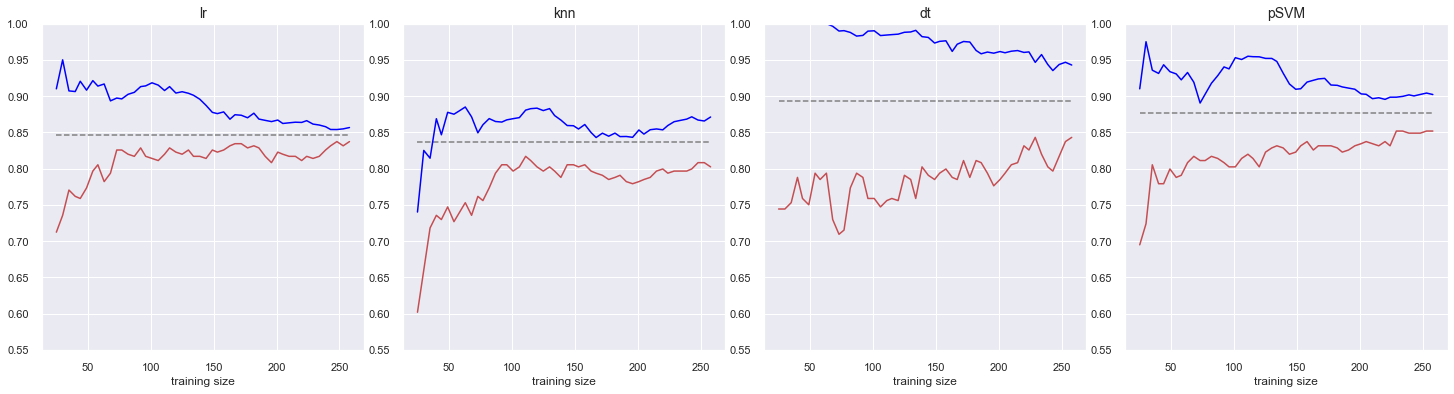

In [168]:
plotLearningCurves( X=Xb_train, y=yb_train, meta= base_learners_meta, cv=cv, 
CVmodels= base_learners , param_names= base_learners_names, baseline_score= 0.55, subkws=dict(left=0.0625, right = 0.95, wspace = 0.12)  )

In [11]:
# **********************results base learners TABLES ************************
#displayCVTables (base_learners_names, base_learners_CV_res, base_learners)

In [12]:

BL = [meta(**param.best_params_) for meta, param in zip(base_learners_meta, base_learners)]
# VOTTING classifier 
v_estimators = [ (f'{name}', estim) for name, estim in zip(base_learners_names, BL)]

In [13]:

# ##########################################ENSEMBLE PARADIGMS ############################################
####### SOFT VOTING 
voting_params={
    #"estimators": v_estimators, 
        #('lr',LRc.best_params_ ),('knn', KNNc.best_params_),('dt', DTc.best_params_), ('pSVM', SVMrbf.best_params_)],
    "voting": ["hard"]
    
}
########BAGING AND PASTING 
# rf (BAGGING) 
rf_params ={
    "bootstrap":[True],
    "criterion":["gini", "entropy"],
    "max_depth":np.arange(2, 21), 
    "n_estimators": np.array(list (50 * x for x in np.arange(1, 11))), 
}
# Rf with outof bag 
rfoob_params ={
    "bootstrap":[True],
    "criterion":["gini", "entropy"],
    "max_depth":np.arange(2, 21), 
    "n_estimators": np.array(list (50 * x for x in np.arange(1, 11))), 
    "oob_score":[True]
}
# extreme tree 
extree_params ={
    "bootstrap":[True],
    "criterion":["gini", "entropy"],
    "max_depth":np.arange(2, 21), 
    "n_estimators": np.array(list (50 * x for x in np.arange(1, 11))), 
    "oob_score":[False]#
}
# extreem tree oob 
extreeoob_params ={
    "bootstrap":[True],
    "criterion":["gini", "entropy"],
    "max_depth":np.arange(2, 21), 
    "n_estimators": np.array(list (50 * x for x in np.arange(1, 11))), 
    "oob_score":[True]
}
# PASTING
past_params = {
    "base_estimator":BL,
     "bootstrap":[False],
    #"criterion":["gini", "entropy"],
    #"max_depth":np.arange(2, 21), 
    "n_estimators": np.array(list (50 * x for x in np.arange(1, 11))), 
 }
######### BOOSTING 
#xgboost 
xgboot_params={
    "max_depth":np.arange(2, 21),
    "learning_rate":np.array(list(x/100 for x in range (1, 21))), 
    "n_estimators": np.array(list (50 * x for x in np.arange(1, 11))), 
    "gamma": np.arange(0, 21)/2, 
    "booster":['gbtree', 'gblinear', 'dart'],
}
# adaboost 

ada_params ={
    "base_estimator":BL,
    "n_estimators": np.array(list (50 * x for x in np.arange(1, 11))),
    "learning_rate":np.array(list(x/100 for x in range (1, 21))), 
}
#########STACKING 

stc_params ={
    #"estimators":v_estimators,
    "final_estimator":BL, #[DecisionTreeClassifier (**DTc.best_params_)],
    "cv":[cv],
}

ensembles =[VotingClassifier (estimators=v_estimators), 
            RandomForestClassifier(),
            RandomForestClassifier(oob_score= True),
            ExtraTreesClassifier(),
            ExtraTreesClassifier(oob_score=True),
            BaggingClassifier(),
            AdaBoostClassifier(),
            XGBClassifier(), 
            StackingClassifier(estimators=v_estimators)
            ]
            
ensembles_names = ['vot',
                    'rf',
                    'rfoob',
                    'extree',
                    'extreeoob', 
                    'past',
                    'ada', 
                    'xgboost', 
                    'stc'
      ]
ensembles_params =[voting_params,
                    rf_params,
                    rfoob_params, 
                    extree_params,
                    extreeoob_params ,
                    past_params,
                    ada_params, 
                    xgboot_params,
                    stc_params
       ]

In [14]:
# _= trainingMultipleModels (X= Xb_train ,
#                             y=yb_train , 
#                             cv=cv, 
#                             param_grids= ensembles_params,
#                             modelnames= ensembles_names,
#                             models=ensembles,
#                             func= RandomizedSearchCV, 
#                             save= True , 
#                             filename= '__el2__',
#     )
__els = joblib.load('__el2__.pkl')


In [166]:
elsObj, elsScores = __els 
votclf = elsObj['vot'].cv_results_ 
pastclf = elsObj['past'].cv_results_ 
xgboostclf = elsObj['xgboost'].cv_results_ 
stcclf = elsObj['stc'].cv_results_ 

# print(rfOOB.keys() )
# print('RFOOB')
# print(rfOOB.get('mean_test_score'))

# rf = elsObj['rf'].cv_results_ 
# print('RF ')
# print(rf['mean_test_score'])

displayCVTables (modelnames=['voting',
                'pasting',
                'xgoost',
#                'stacking'
   ],CVresults=[votclf,
                pastclf,
                xgboostclf,
#                stcclf
      ], CVmodels=[
                elsObj['vot'], 
                elsObj['past'],
                elsObj['xgboost'],
#               elsObj['stc']
]
      )

stcclf

voting :
split =CV1:
{'param': {'voting': 'hard'}, 'accuracy_score': 0.8517441860465117, 'std_score': 0.038013653577389575, 'CV1_score': 0.9069767441860465, 'CV1_mean_score': 0.9069767441860465}
split =CV2:
{'param': {'voting': 'hard'}, 'accuracy_score': 0.8517441860465117, 'std_score': 0.038013653577389575, 'CV1_score': 0.9069767441860465, 'CV1_mean_score': 0.9069767441860465}
split =CV3:
{'param': {'voting': 'hard'}, 'accuracy_score': 0.8517441860465117, 'std_score': 0.038013653577389575, 'CV2_score': 0.8604651162790697, 'CV2_mean_score': 0.8604651162790697}
split =CV4:
{'param': {'voting': 'hard'}, 'accuracy_score': 0.8517441860465117, 'std_score': 0.038013653577389575, 'CV3_score': 0.8372093023255814, 'CV3_mean_score': 0.8372093023255814}
Global split scores:
mean= 0.8517441860465117 std= 0.038013653577389575
BestParams:  {'voting': 'hard'}
Best scores: 0.8517441860465117

pasting :
split =CV1:
{'param': {'n_estimators': 150, 'bootstrap': False, 'base_estimator': SVC(C=2.0, coef0=0

{'mean_fit_time': array([0.14312965, 0.0395354 , 0.02878523, 0.01651412]),
 'std_fit_time': array([0.05146142, 0.04074637, 0.0164289 , 0.00150154]),
 'mean_score_time': array([0., 0., 0., 0.]),
 'std_score_time': array([0., 0., 0., 0.]),
 'param_final_estimator': masked_array(data=[LogisticRegression(),
                    KNeighborsClassifier(metric='manhattan', n_neighbors=9),
                    DecisionTreeClassifier(criterion='entropy', max_depth=7),
                    SVC(C=2.0, coef0=0, degree=1, gamma=0.125)],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_cv': masked_array(data=[list([(array([ 80,  85,  86,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
                            99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
                           112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
                           125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 13

In [162]:
stcobj= GridSearchCV (StackingClassifier(estimators=v_estimators), param_grid=stc_params, scoring ='accuracy')

try : 
    scores= cross_val_score(stcobj, Xb_train, yb_train, scoring ='accuracy' , cv =4 )
    #print(f'{param_grid ["kernel"][0]}: CV accuracy: %3.f +/- %3.f' %(np.mean(scores), np.std(scores)) )
    print(f'{stcobj.__class__.__name__}: CV accuracy: %3.f +/- %3.f' %(np.mean(scores), np.std(scores)) )
except:pass 

stcobj = stcobj.fit(Xb_train, yb_train)
stcobj.best_score_ 
stcobj.best_params_ 

GridSearchCV: CV accuracy: nan +/- nan


{'cv': [(array([ 80,  85,  86,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
           99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
          112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
          125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
          138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
          151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
          164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
          177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189,
          190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202,
          203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215,
          216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228,
          229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241,
          242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254,
          255, 256,

In [94]:
# Best model 
vtm =VotingClassifier( estimators =v_estimators , voting ='hard') # 0.8517441860465117
rfm = RandomForestClassifier (
    **{'n_estimators': 350, 'max_depth': 16, 'criterion': 'entropy', 'bootstrap': True}
    ) # 0.8430232558139535
rfmoob=RandomForestClassifier (
    **{'oob_score': True, 'n_estimators': 100, 'max_depth': 15, 'criterion': 'gini', 'bootstrap': True}
    ) # 0.8488372093023256
extreem = ExtraTreesClassifier (
    **{'oob_score': False, 'n_estimators': 450, 'max_depth': 19, 'criterion': 'entropy', 'bootstrap': True}
    ) # 0.8284883720930233
extreeoobm = ExtraTreesClassifier (
    **{'oob_score': True, 'n_estimators': 300, 'max_depth': 18, 'criterion': 'entropy', 'bootstrap': True}
    ) # 0.8343023255813954
pastm = BaggingClassifier (
    **{'n_estimators': 150, 'bootstrap': False, 'base_estimator': SVC(C=2.0, coef0=0, degree=1, gamma=0.125)}
    ) # 0.8517441860465117
adam = AdaBoostClassifier (
    **{'n_estimators': 50, 'learning_rate': 0.06, 'base_estimator': DecisionTreeClassifier(criterion='entropy', max_depth=7)}
    ) # 0.8546 
xgboostm = XGBClassifier (
    **{'n_estimators': 300, 'max_depth': 2, 'learning_rate': 0.07, 'gamma': 1.5, 'booster': 'gbtree'}
    ) # 0.8633
stcm = StackingClassifier (
    **{'estimators': v_estimators , 'final_estimator':LogisticRegression (C=1, penalty= 'l2')}
    ) # 0.86662

bmodels = (vtm, rfm, rfmoob, extreem, extreeoobm, pastm, adam, xgboostm, stcm)
#savef (data =models , fn = '__bestm__')

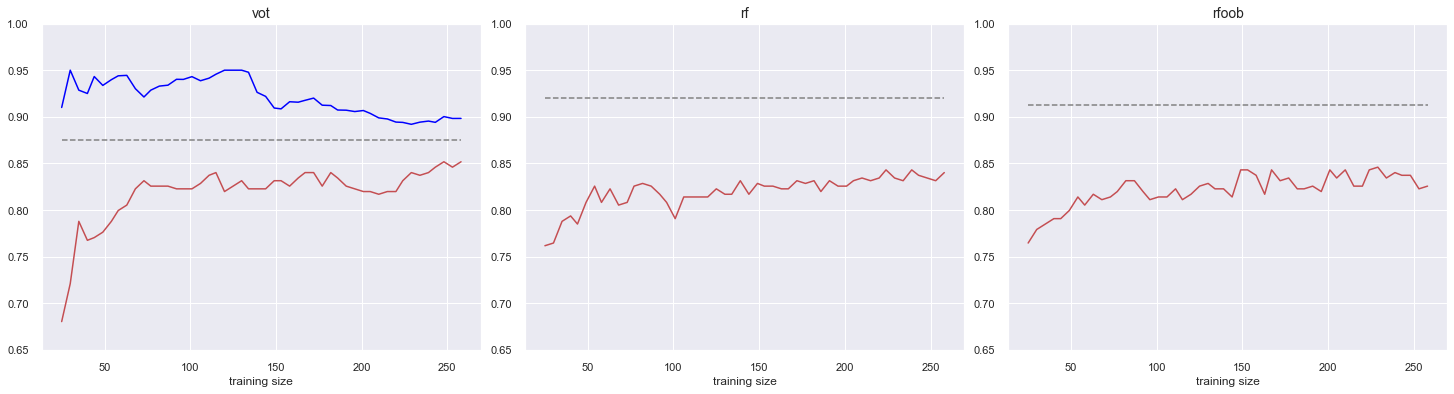

In [95]:
bmbag1 = list(bmodels)[:3]
ens_bag1_meta = [VotingClassifier , RandomForestClassifier, RandomForestClassifier]
plotLearningCurves2 ( model_list=  bmbag1, X=Xb_train, y=yb_train, param_names= ensembles_names[:3], 
  ncol =3 ,figsize=(22, 6), baseline_score=0.65)
  

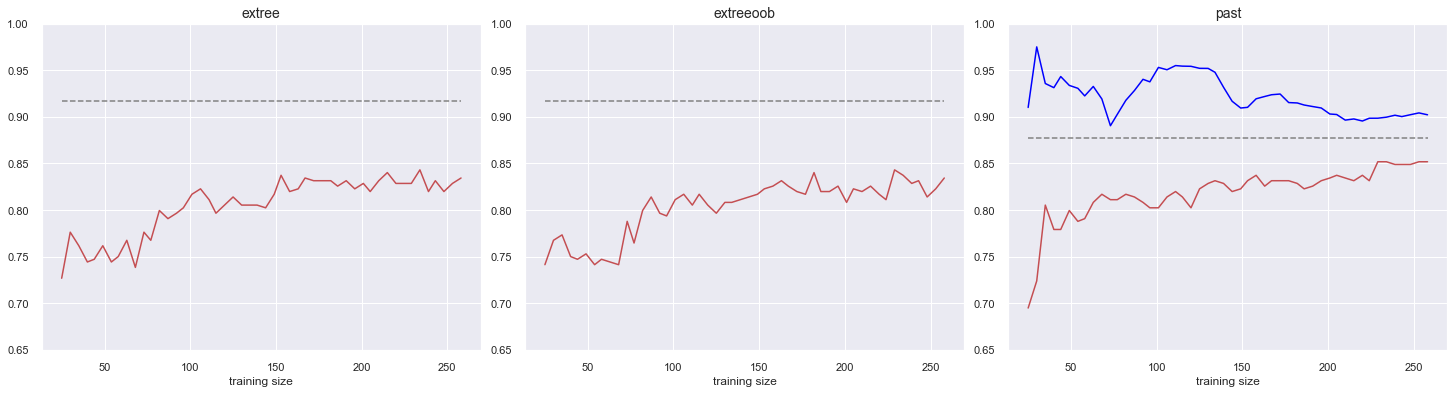

In [96]:
bmbag2 = list(bmodels)[3:6]
ens_bag2_meta = [ExtraTreesClassifier, ExtraTreesClassifier , BaggingClassifier]
plotLearningCurves2 ( model_list=  bmbag2, X=Xb_train, y=yb_train, param_names= ensembles_names[3:6], 
  ncol =3 ,figsize=(22, 6), baseline_score=0.65)

In [97]:
    
# fig, axis = plt.subplots( figsize =(6,4))#figsize =(22, 6))
# fig, axis0 = plt.subplots( 1,3, figsize =(22, 6))
# fig, axis1 = plt.subplots( 1,3, figsize =(22, 6))
# fig, axis2 = plt.subplots( 1,3, figsize =(22, 6))


# for i in range (3): 
#     lc_viz = LearningCurve (bmodels[i], cv=cv , ax=axis0 [i] )
#     lc_viz.fit(Xb_train, yb_train) 

# for i in range (3, 6): 
#     k =3
#     lc_viz = LearningCurve (bmodels[i], cv=cv , ax=axis1 [i-k] )
#     lc_viz.fit(Xb_train, yb_train) 

# for i in range (6, 9): 
#     k =6
#     lc_viz = LearningCurve (bmodels[i], cv=cv , ax=axis2 [i-k] )
#     lc_viz.fit(Xb_train, yb_train) 
#     if i ==8: 
#         lc_viz.show() 

#lc_viz.show()  
# lc_viz = LearningCurve (bmodels[1], cv=cv , ax=axis [1] )
# lc_viz.fit(Xb_train, yb_train) 
# #lc_viz.show()  
# lc_viz = LearningCurve (bmodels[2], cv=cv , ax=axis [2] )
# lc_viz.fit(Xb_train, yb_train) 
 


In [98]:
fmodels = (vtm,  pastm,  xgboostm, stcm)

#fig, axis0 = plt.subplots( 1,2, figsize =(15, 5))
#fig, axis1 = plt.subplots( 1,2, figsize =(15, 5))
#yellowLearningCurvesplot2(list(fmodels)[:2] , Xb_train, yb_train , ax = axis0  )
#yellowLearningCurvesplot2(list(fmodels)[2:] , Xb_train, yb_train , ax = axis1  )

In [99]:
# ensemlble learning 1 *********************
#ensgridObjs, ensgridScores = joblib.load('ensemble_learning_.pkl')
# ensemble learning 2*******************
# ensgridObjs, ensgridScores = joblib.load('__el2__.pkl')
# #savef(data = ensemble_data  , fn ='ensemble_learning_' )
# ensgridObjs.get('vot').cv_results_

# vot_clf= ensgridObjs.get('vot')
# rf_clf=  ensgridObjs.get('rf')
# rfoob_clf=  ensgridObjs.get('rfoob')
# extree_clf=  ensgridObjs.get('extree')
# extreeoob_clf=  ensgridObjs.get('extreeoob')
# past_clf = ensgridObjs.get('past')
# ada_clf=  ensgridObjs.get('ada')
# xgb_clf = ensgridObjs.get('xgboost')
# stc_clf=  ensgridObjs.get('stc')


# cvres_vot = vot_clf.cv_results_
# cvres_rf= rf_clf.cv_results_
# cvres_rfoob= rfoob_clf.cv_results_
# cvres_extree= extree_clf.cv_results_
# cvres_extreeoob=extreeoob_clf.cv_results_
# cvres_past = past_clf.cv_results_
# cvres_ada = ada_clf.cv_results_
# cvres_xgb= xgb_clf.cv_results_
# cvres_stc= stc_clf.cv_results_

# ensemble_clfs = [vot_clf,
#                 rf_clf, 
#     rfoob_clf,
#     extree_clf,
#     extreeoob_clf,

#                 past_clf ,
#                 ada_clf,
#                 xgb_clf,
#                 stc_clf 
#     ] 
# ensembleCV_res =[cvres_vot,
#                 cvres_rf, 
#     cvres_rfoob, 
#     cvres_extree, 
#     cvres_extreeoob,
#                 cvres_past, 
#                 cvres_ada,
#                 cvres_xgb,
#                 cvres_stc 
#    ]
# ensembles_meta =[VotingClassifier , 
#                 RandomForestClassifier, 
#         RandomForestClassifier, 
#         ExtraTreesClassifier, 
#         ExtraTreesClassifier, 
#             BaggingClassifier,
#             AdaBoostClassifier,
#             XGBClassifier, 
#             StackingClassifier]

#plotLearningCurves ( meta= None , CVmodels=ensemble_clfs , param_names= ensembles_names, ncol =6 ,figsize=(30, 6))

In [100]:
# print ensembles fine tunes results 
# displayFineTuneResults(meta=ensembles_meta, CVmodels =ensemble_clfs)

In [101]:
# **********************results ensemble learners TABLES ************************
# displayCVTables(ensembles_names, ensembleCV_res, ensemble_clfs)

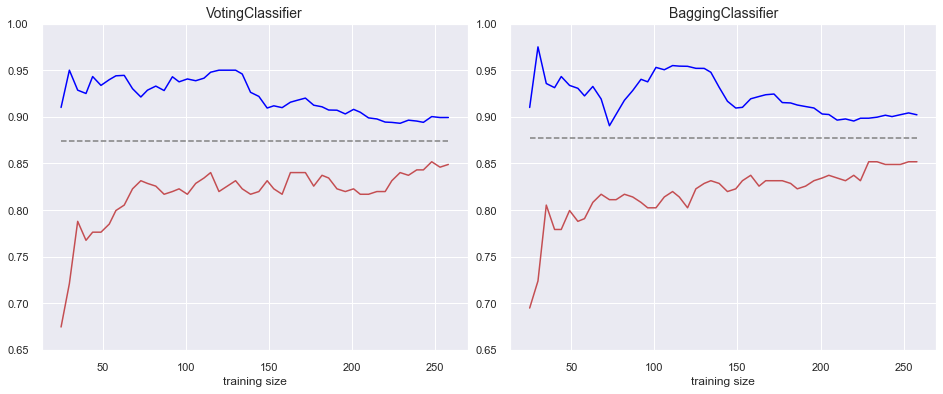

In [102]:
# ens_bag1_clfs  = [vot_clf, rf_clf, past_clf ]
# ens_bag1_CV_res =[cvres_vot, cvres_rf,  cvres_past]
# ens_bag1_meta = [VotingClassifier , RandomForestClassifier, BaggingClassifier]
# plotLearningCurves ( meta= None , X=Xb_train, y=yb_train, 
#  CVmodels=ens_bag1_clfs, param_names= ens_bag1_meta,
#   ncol =2 ,figsize=(22, 6), baseline_score=0.65)

plotLearningCurves2(model_list= list(fmodels)[:2],
X=Xb_train, 
y=yb_train, cv =cv , param_names=None, ncol= 2 , figsize= (14, 6), baseline_score= 0.65)


[13:50:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:50:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:50:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:50:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

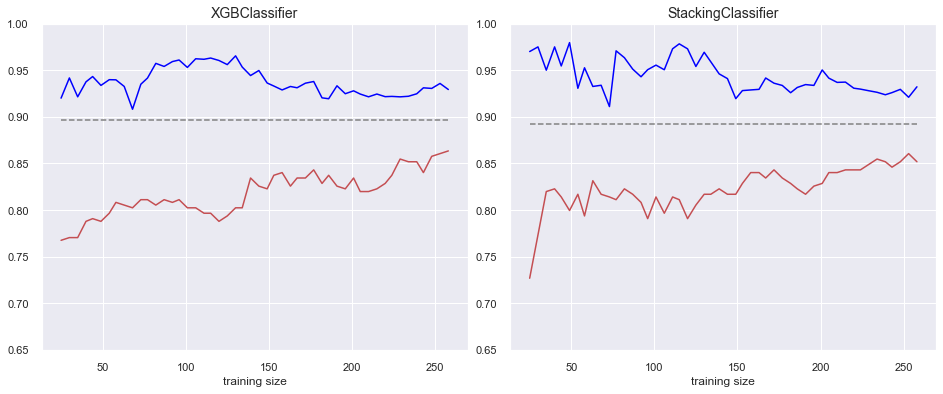

In [103]:
plotLearningCurves2(model_list= list(fmodels)[2:],
X=Xb_train, 
y=yb_train, cv =cv , param_names=None, ncol= 2 , figsize= (14, 6), baseline_score= 0.65)

In [104]:
festimators = [(f'{model.__class__.__name__}', model) for model in fmodels]
# STF= StackingClassifier (estimators= festimators ,
#  final_estimator= xgboostm)

#plotLearningCurves2 (model_list= [STF], X=Xb_train, y=yb_train, cv =cv, ncol=2 , figsize= (14, 6), baseline_score= 0.65)


# for finestim in  [LRc, KNNc , DTc , SVMrbf ] : 
#     STF= StackingClassifier (estimators= festimators ,
#     final_estimator= finestim.best_estimator_)
#     plotLearningCurves2 (model_list= [STF], X=Xb_train, y=yb_train, cv =cv, ncol=2 , figsize= (22, 6), baseline_score= 0.65)
# ens_bag2_clfs  = [ada_clf, xgb_clf, stc_clf ]
# ens_bag2_CV_res =[cvres_ada,cvres_xgb, cvres_stc]
# ens_bag2_meta = [AdaBoostClassifier,XGBClassifier, StackingClassifier]

# plotLearningCurves ( meta= None, X=Xb_train, y=yb_train, 
# CVmodels=ens_bag2_clfs, param_names= ens_bag2_meta, 
# ncol =3 ,figsize=(22, 6), baseline_score =0.65)

In [119]:
fmodelnames = [model.__class__.__name__ for model in fmodels ]

In [105]:
base_lea= [m.best_estimator_ for m in base_learners] 

#plotTwoFeaturesDecisionStump(Xb_train[:, :2], yb_train, list(fmodels), figsize= (22, 6))

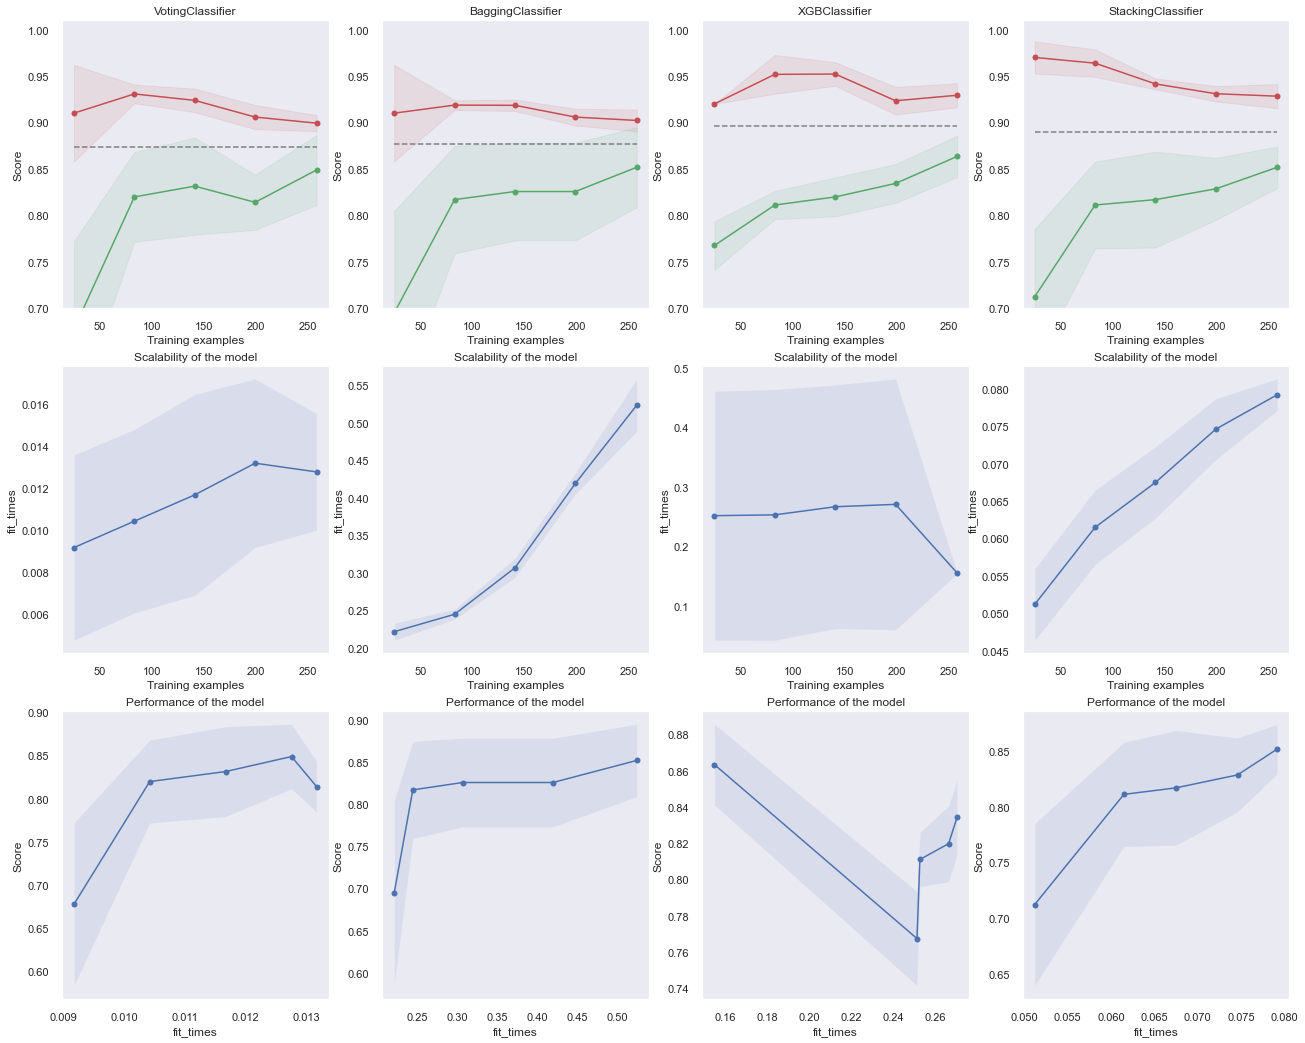

In [171]:
fig, axes = plt.subplots(3, 4, figsize=(22, 18))
for kk, model in enumerate( fmodels): 
    plot_learning_curve(
        model, model.__class__.__name__, X=Xb_train, y=yb_train, axes=axes[:,kk], ylim=(0.7, 1.01), cv=cv, n_jobs=4, viz_legend= False)

fig.savefig ('Training_and_fit_scoresnolegend.png', dpi = 300)
plt.show()




# FR predictions 

LogisticRegression : accuracy -score =  0.8620689655172413
LogisticRegression : recall -score =  0.8409090909090909
LogisticRegression : precision -score =  0.8809523809523809
LogisticRegression : ROC AUC-score =  0.8623150105708245
KNeighborsClassifier : accuracy -score =  0.8160919540229885
KNeighborsClassifier : recall -score =  0.8409090909090909
KNeighborsClassifier : precision -score =  0.8043478260869565
KNeighborsClassifier : ROC AUC-score =  0.8158033826638478
DecisionTreeClassifier : accuracy -score =  0.8160919540229885
DecisionTreeClassifier : recall -score =  0.75
DecisionTreeClassifier : precision -score =  0.868421052631579
DecisionTreeClassifier : ROC AUC-score =  0.8168604651162791
SVC : accuracy -score =  0.8735632183908046
SVC : recall -score =  0.8636363636363636
SVC : precision -score =  0.8837209302325582
SVC : ROC AUC-score =  0.873678646934461


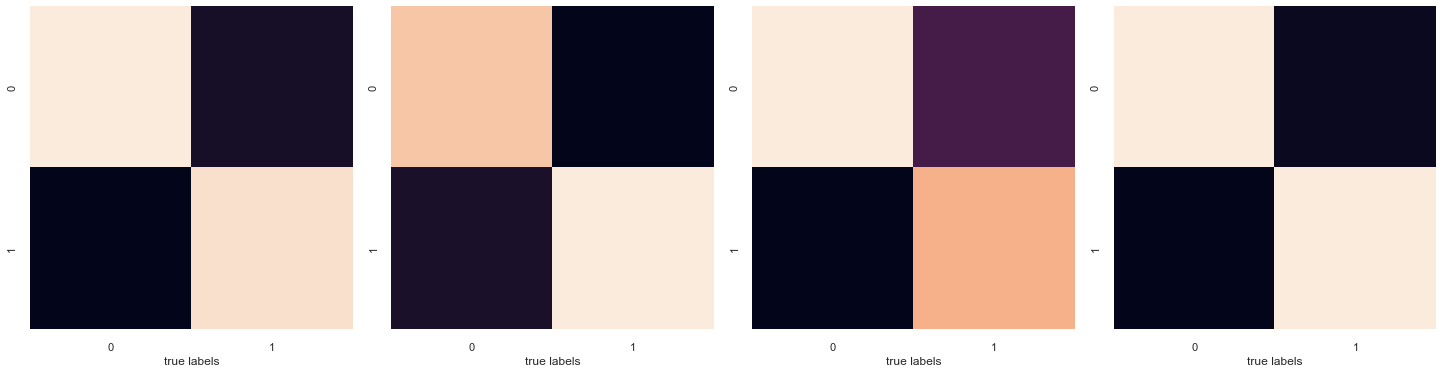

In [169]:
fig, ax = plt.subplots(1, 4, figsize =(22, 6))
fig.subplots_adjust(left=0.0625, right = 0.95, wspace = 0.12)

multipleEvaluationKplus(Xb_test, yb_test, 
models = [m.best_estimator_ for m in base_learners], 
 axis =ax , annot=False)

[19:15:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
VotingClassifier : accuracy -score =  0.8505747126436781
VotingClassifier : recall -score =  0.7727272727272727
VotingClassifier : precision -score =  0.918918918918919
VotingClassifier : ROC AUC-score =  0.8514799154334038
BaggingClassifier : accuracy -score =  0.8735632183908046
BaggingClassifier : recall -score =  0.8636363636363636
BaggingClassifier : precision -score =  0.8837209302325582
BaggingClassifier : ROC AUC-score =  0.873678646934461
XGBClassifier : accuracy -score =  0.896551724137931
XGBClassifier : recall -score =  0.8863636363636364
XGBClassifier : precision -score =  0.9069767441860465
XGBClassifier : ROC AUC-score =  0.8966701902748414
StackingClassifier : accur

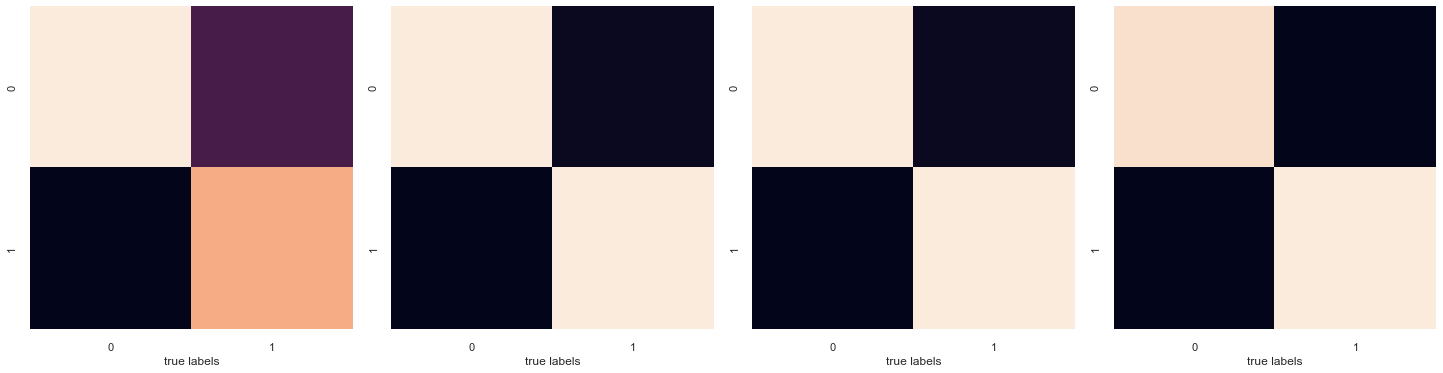

In [172]:
fig, ax = plt.subplots(1, 4, figsize =(22, 6))
fig.subplots_adjust(left=0.0625, right = 0.95, wspace = 0.12)
#call fit before 
fmodels =[clf.fit(Xb_train, yb_train) for clf in fmodels]
multipleEvaluationKplus(Xb_test, yb_test, models = fmodels,  axis =ax , annot=False )


In [111]:
#SVMs = [Votm, Pastm, Xgboostm, Stackm ] 

# votmplus = plot_roc_curve(fmodels[0], Xb_test, yb_test)
# pastmplus = plot_roc_curve(fmodels[1], Xb_test, yb_test, ax= votmplus.ax_)
# xgboostmplus = plot_roc_curve(fmodels[2], Xb_test, yb_test, ax= votmplus.ax_)
# stackmplus = plot_roc_curve(fmodels[3], Xb_test, yb_test, ax= votmplus.ax_)

# stackmplus.figure_.suptitle('ROC CURVE comparison')

def plotMutipleROCcurves(models, XT, yT): 
    for idx, mod in enumerate(models): 
        try: 
            if idx ==0: 
                initax = plot_roc_curve(mod, XT, yT)
            elif idx == len(models)-1: 
                stackmplus = plot_roc_curve(mod, XT, yT, ax= initax.ax_)
                stackmplus.figure_.suptitle('ROC CURVE comparison')
            else:
                plot_roc_curve(mod, XT, yT, ax= initax.ax_)
        except: pass 

In [112]:
plotMutipleROCcurves(fmodels, Xb_test, yb_test)

Text(0.5, 0.98, 'ROC CURVE comparison')

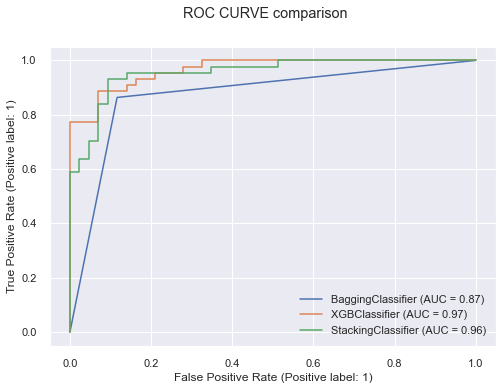

In [114]:
#votmplus = plot_roc_curve(fmodels[0], Xb_test, yb_test)
pastmplus = plot_roc_curve(fmodels[1], Xb_test, yb_test)
xgboostmplus = plot_roc_curve(fmodels[2], Xb_test, yb_test, ax= pastmplus.ax_)
stackmplus = plot_roc_curve(fmodels[3], Xb_test, yb_test, ax= pastmplus.ax_)

stackmplus.figure_.suptitle('ROC CURVE comparison')

In [118]:
#votmplus = plot_roc_curve(fmodels[0], Xb_test, yb_test)
# for model in list(fmodels)[1:]:
#     try:
#         rocaucFromYellowbrick(model, Xb_test, yb_test)
#     except: pass 
    

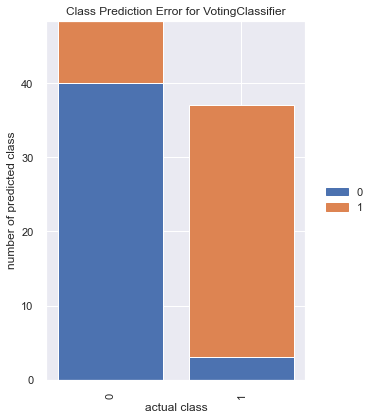

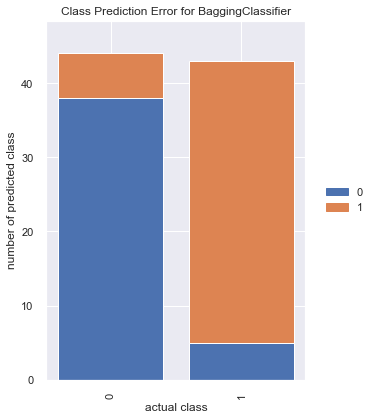

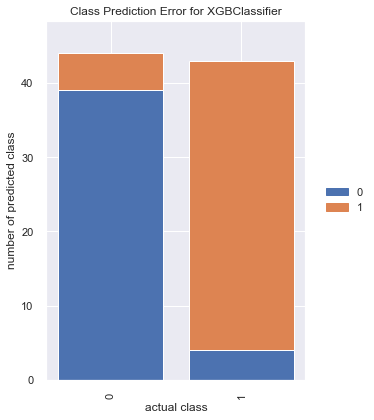

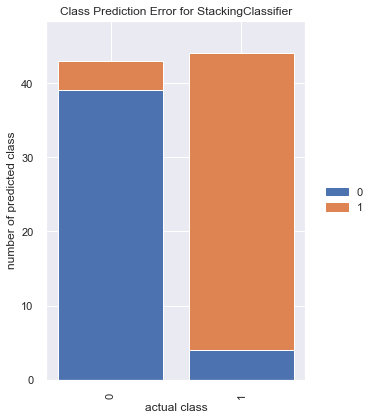

In [120]:
fmodels =deepcopy(fmodels)
for kk, (model , modnames) in enumerate(zip(fmodels, fmodelnames)): 
    classPredictorError(model, Xb_test, yb_test)

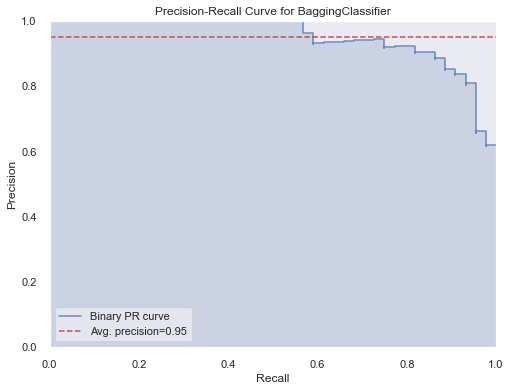

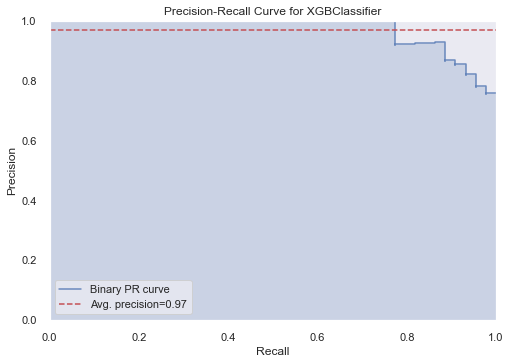

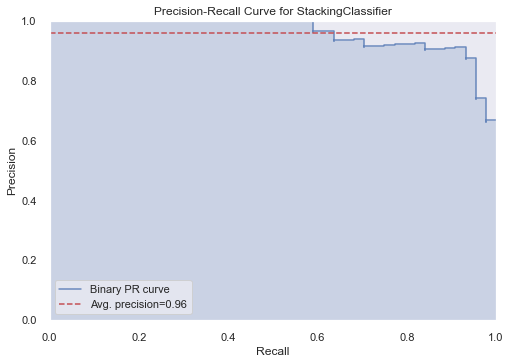

In [131]:
fig, ax = plt.subplots(1, 1, figsize =(8, 6))
for kk, (model , modnames) in enumerate(zip(fmodels, fmodelnames )): 
      try:
            precisionRecallCurveFromYellowbrick(model,Xb_train, yb_train,  XT= Xb_test, yT= yb_test, fig= fig)
      except: pass 



In [132]:
for kk, (model , modnames) in enumerate(zip(fmodels, fmodelnames )): 
     try:
          precisionRecallCurveFromYellowbrick(model,Xb_train, yb_train, XT= Xb_test, yT= yb_test , axis =ax[kk])
     except:pass 


In [123]:
for kk, (model , modnames) in enumerate(zip(fmodels, fmodelnames )): 
    avgprec_scores= averagePrecisionScore (model, Xb_test, y=yb_test)
    print(f"{modnames} : average precision-score = ", avgprec_scores)

VotingClassifier : average precision-score =  0.8250162388093423
BaggingClassifier : average precision-score =  0.8321790478967704
XGBClassifier : average precision-score =  0.8613824694418118
StackingClassifier : average precision-score =  0.8724232924859884


In [134]:
# for kk, (model , modnames) in enumerate(zip(fmodels, fmodelnames )): 
#      try:
#           rocaucFromYellowbrick(model, XT= Xb_test, yT= yb_test )
#      except:pass 


In [156]:
def ROC(X, y, XT, yT, model, figsize =(8, 8), figname = None, classes =['FR0', 'FR1']): 
    fig, ax =plt.subplots(figsize =figsize)
    roc_viz = ROCAUC(model, classes = classes )
    roc_viz.fit(X, y)
    roc_viz.score (XT, yT)
    roc_viz.show()
    if figname is not None:
        figname =str(figname )
        fig.savefig (figname , dpi=300)



In [141]:
#!pip install scikit-plot 

def cumulativeGainPlot(XT, yT, model, figsize =(6, 6), figname = None): 
    fig, ax =plt.subplots(figsize =figsize)
    y_probas = model.predict_proba(XT)
    scikitplot.metrics.plot_cumulative_gain(yT, y_probas, ax=ax )
    if figname is not None:
        figname =str(figname )
        fig.savefig (figname , dpi=300, bbox_inches = 'tight'
        )


In [142]:
def  liftCurve(XT, yT, model, figsize =(6, 6), figname = None): 
    fig, ax =plt.subplots(figsize =figsize)
    y_probas = model.predict_proba(XT)
    scikitplot.metrics.plot_lift_curve(yT, y_probas, ax=ax )
    if figname is not None:
        figname =str(figname )
        fig.savefig (figname , dpi=300, bbox_inches = 'tight'
        )

NAME = VotingClassifier
NAME = BaggingClassifier
NAME = XGBClassifier
NAME = StackingClassifier


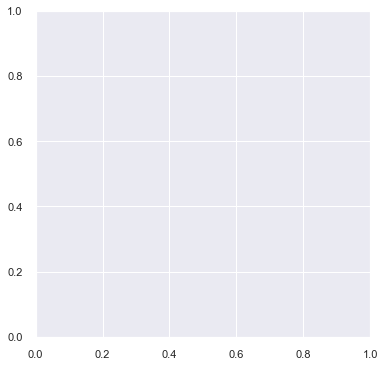

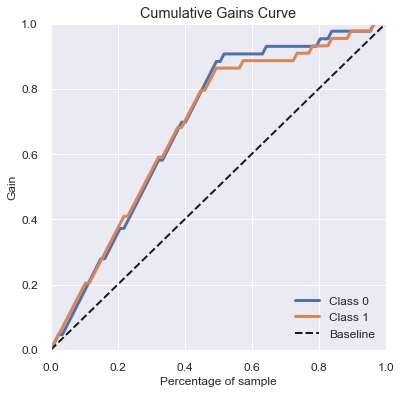

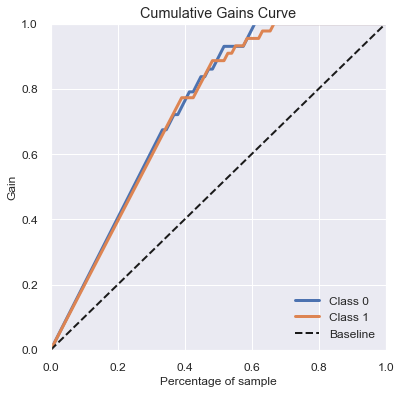

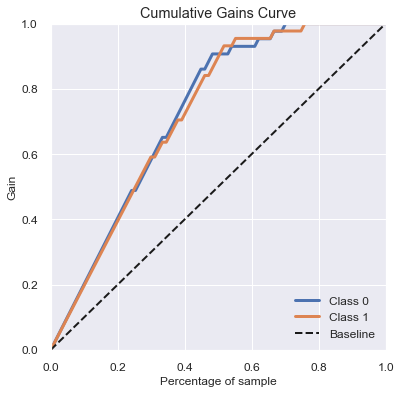

In [149]:
#ROC(model= fmodels[1], XT=Xb_test, yT=yb_test)
for model , name in zip(fmodels, fmodelnames) : 
    try :
        print("NAME =", name )
        cumulativeGainPlot(model= model, XT=Xb_test, yT=yb_test)
    except: pass 

NAME = VotingClassifier
NAME = BaggingClassifier
NAME = XGBClassifier
NAME = StackingClassifier


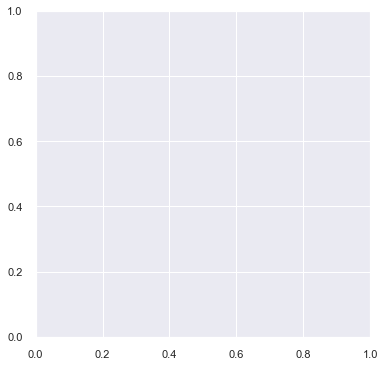

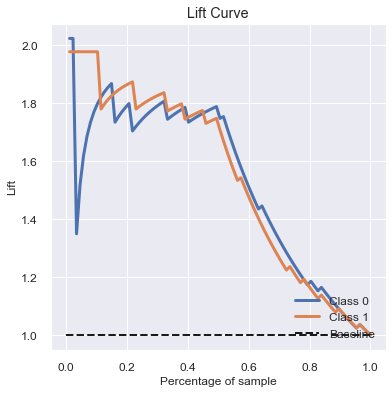

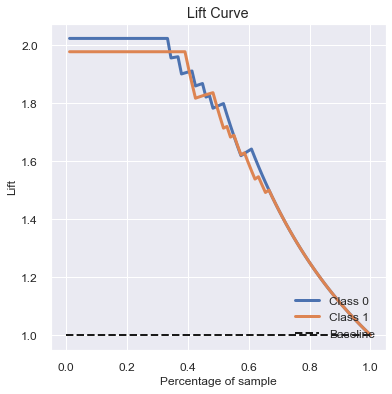

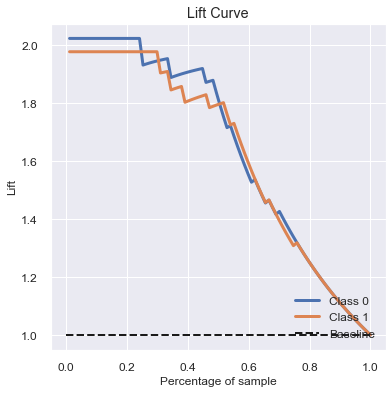

In [150]:
for model , name in zip(fmodels, fmodelnames) : 
    try :
        print("NAME =", name )
        liftCurve(model= model, XT=Xb_test, yT=yb_test)
    except: pass 

NAME = VotingClassifier
NAME = BaggingClassifier


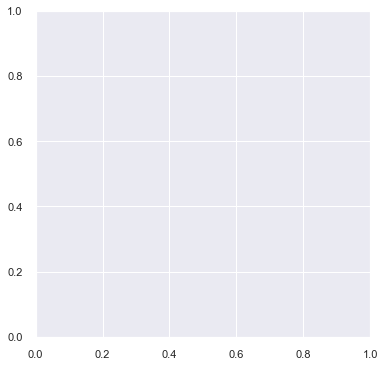

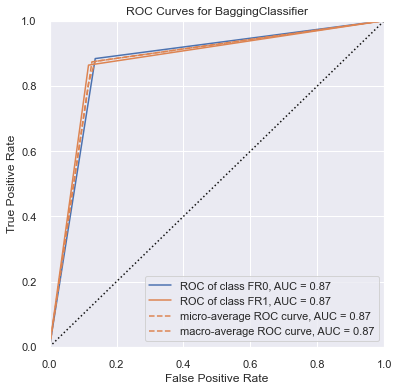

NAME = XGBClassifier


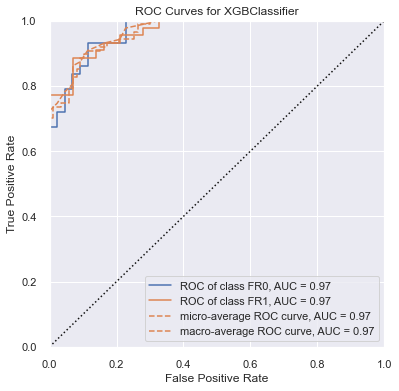

NAME = StackingClassifier


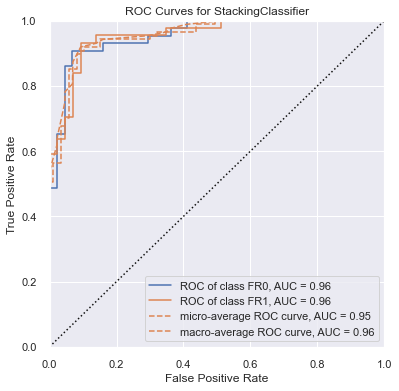

In [158]:
for model , name in zip(fmodels, fmodelnames) : 
    try :
        print("NAME =", name )
        ROC(Xb_train, yb_train, Xb_test, yb_test, model=model, figsize =(6, 6))
    except: pass 

